# Linear regression
Using the preprocessed dataset we will train a linear regressor to predict the global score.

In [2]:
#!pip install missingno
#!pip install category-encoders

    100% |████████████████████████████████| 81kB 248kB/s ta 0:00:01
    100% |████████████████████████████████| 13.5MB 4.5MB/s ta 0:00:011
  Found existing installation: numpy 1.13.3
    Uninstalling numpy-1.13.3:
      Successfully uninstalled numpy-1.13.3


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf #Working on Docker
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
#import missingno as msno
from src import funcs
#from statsmodels.formula.api import ols

from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer, MaxAbsScaler, OneHotEncoder
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression
#from category_encoders import OneHotEncoder

## Dataset loading

In [2]:
df_all = pd.read_csv('./saberpro_2016-2019_cleaned_v4.zip',sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (10,11,12,14,25,26,39,42,43,44,92,93,98,106) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_2019 = df_all[df_all['YEAR']==2019]
df_N2019 = df_all[df_all['YEAR']!=2019]

df_devel, df_test = train_test_split(df_2019, test_size=0.2, random_state=666)
df_devel = pd.concat([df_devel,df_N2019])
df_clean, df_val = train_test_split(df_devel, test_size=0.05, random_state=667)

#Saving dict with types
#dic_types = {col: dtype for col, dtype in zip(list(df_all.columns),list(df_all.dtypes))}
  
#df_clean = df_clean.astype(dic_types)
#df_val = df_val.astype(dic_types)
#df_test = df_test.astype(dic_types)

print(df_test['YEAR'].unique())
print(df_clean['YEAR'].unique(), df_val['YEAR'].unique())
print('-------------------------------------------')
print(df_clean.shape, df_val.shape, df_test.shape)

[2019]
[2016 2017 2018 2019] [2016 2019 2017 2018]
-------------------------------------------
(865679, 111) (45563, 111) (52013, 111)


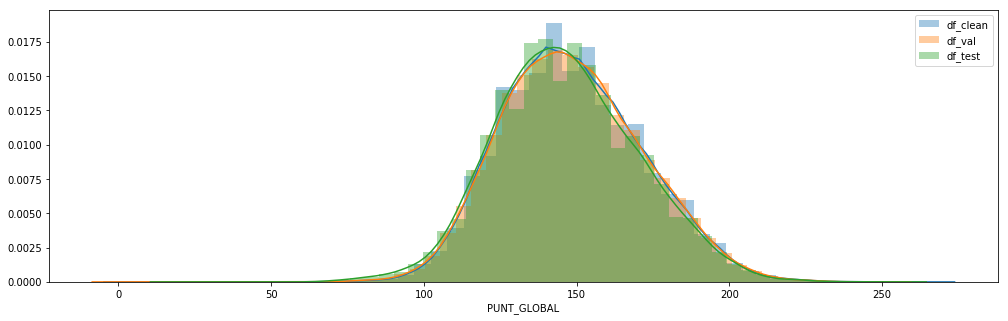

In [4]:
fig, axes = plt.subplots(figsize=(17, 5))

sns.distplot(df_clean['PUNT_GLOBAL'], label='df_clean')
sns.distplot(df_val['PUNT_GLOBAL'], label='df_val')
sns.distplot(df_test['PUNT_GLOBAL'], label='df_test')

plt.legend()
plt.show()

## Model - Preprocessing (Applying pipeline)

In [5]:
class ColumnExtractor(BaseEstimator, TransformerMixin):

    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols

def create_feat(df):

    #Nacionalidad
    filter_nac = (df['ESTU_NACIONALIDAD']!='COLOMBIA')&(df['ESTU_NACIONALIDAD'].notnull())
    df.loc[filter_nac,'ESTU_NACIONALIDAD'] = 0

    filter_nac = df['ESTU_NACIONALIDAD']=='COLOMBIA'
    df.loc[filter_nac,'ESTU_NACIONALIDAD'] = 1

    #df['ESTU_NACIONALIDAD'] = df['ESTU_NACIONALIDAD'].astype('bool')

    #Método programa
    filter_nac = (df['ESTU_METODO_PRGM'] == 'DISTANCIA') | (df['ESTU_METODO_PRGM'] == 'SEMI-PRESENCIAL')
    df.loc[filter_nac,'ESTU_METODO_PRGM'] = 'DISTANCIA/SEMI-PRESENCIAL'

    filter_nac = df['ESTU_METODO_PRGM'] == 'DISTANCIA VITUAL'
    df.loc[filter_nac,'ESTU_METODO_PRGM'] = 'DISTANCIA VIRTUAL'

    #Carácter académico
    filter_nac = (df['INST_CARACTER_ACADEMICO']=='INSTITUCIÓN TECNOLÓGICA') |\
                 (df['INST_CARACTER_ACADEMICO']=='INSTITUCIÓN UNIVERSITARIA')
    df.loc[filter_nac,'INST_CARACTER_ACADEMICO'] = 'TECNOLÓGICA/UNIVERSITARIA'
    
    #Institución educativa
    l_inst = ['CORPORACION UNIVERSITARIA MINUTO DE DIOS','POLITECNICO GRANCOLOMBIANO',
              'UNIVERSIDAD COOPERATIVA DE COLOMBIA','UNIVERSIDAD NACIONAL ABIERTA Y A DISTANCIA UNAD',
              'UNIVERSIDAD NACIONAL DE COLOMBIA','FUNDACION UNIVERSITARIA DEL AREA ANDINA','UNIVERSIDAD LIBRE',
              'UNIVERSIDAD DE ANTIOQUIA','UNIVERSIDAD SANTO TOMAS','PONTIFICIA UNIVERSIDAD JAVERIANA',
              'CORPORACION UNIFICADA NACIONAL DE EDUCACION SUPERIOR','UNIVERSIDAD DEL TOLIMA',
              'CORPORACION UNIVERSITARIA REMINGTON','UNIVERSIDAD PONTIFICIA BOLIVARIANA',
              'UNIVERSIDAD PEDAGOGICA Y TECNOLOGICA DE COLOMBIA','UNIVERSIDAD DEL ATLANTICO',
              'UNIVERSIDAD DE PAMPLONA','UNIVERSIDAD DEL QUINDIO','UNIVERSIDAD FRANCISCO DE PAULA SANTANDER',
              'UNIVERSIDAD DE LOS ANDES','UNIVERSIDAD DEL VALLE','UNIVERSIDAD ANTONIO NARIÑO',
              'UNIVERSIDAD DE CARTAGENA','UNIVERSIDAD DE SAN BUENAVENTURA',
              'CORPORACION UNIVERSITARIA IBEROAMERICANA','UNIVERSIDAD SIMON BOLIVAR',
              'UNIVERSIDAD INDUSTRIAL DE SANTANDER','UNIVERSIDAD DE LA SALLE','UNIVERSIDAD LA GRAN COLOMBIA',
              'UNIVERSIDAD DEL MAGDALENA','UNIVERSIDAD SANTIAGO DE CALI',
              'UNIVERSIDAD DISTRITALFRANCISCO JOSE DE CALDAS','CORPORACION UNIVERSITARIA DEL CARIBE',
              'UNIVERSIDAD ECCI','UNIVERSIDAD MILITARNUEVA GRANADA','FUNDACION UNIVERSITARIA LUIS AMIGO FUNLAM',
              'UNIVERSIDAD DE CORDOBA','FUNDACION UNIVERSITARIA LOS LIBERTADORES','UNIVERSIDAD DEL NORTE',
              'UNIVERSIDAD DE CUNDINAMARCA','UNIVERSIDAD TECNOLOGICA DE PEREIRA','UNIVERSIDAD POPULAR DEL CESAR',
              'UNIVERSIDAD DEL CAUCA','FUNDACION UNIVERSIDAD DE BOGOTAJORGE TADEO LOZANO',
              'CORPORACION UNIVERSIDAD DE LA COSTA, CUC','ESCUELA SUPERIOR DE ADMINISTRACION PUBLICA',
              'UNIVERSIDAD EL BOSQUE','UNIVERSIDAD DE LA GUAJIRA','UNIVERSIDAD AUTONOMA DEL CARIBE',
              'UNIVERSIDAD CATOLICA DE COLOMBIA','UNIVERSIDAD EAFIT','UNIVERSIDAD DE MEDELLIN',
              'COLEGIO MAYOR DE NUESTRA SEÑORA DEL ROSARIO','FUNDACION UNIVERSITARIA SAN MARTIN',
              'UNIVERSIDAD SURCOLOMBIANA','UNIVERSIDAD DE CALDAS','UNIVERSIDAD CENTRAL','UNIVERSIDAD DE LA SABANA',
              'UNIVERSIDAD DEL SINÚ Elías Bechara Zainúm','UNIVERSIDAD SERGIO ARBOLEDA','UNIVERSIDAD DE SANTANDER',
              'UNIVERSIDAD AUTONOMA DE OCCIDENTE','CORPORACION UNIVERSITARIA AMERICANA']

    df['INST_NOMBRE_INSTITUCION'] = df['INST_NOMBRE_INSTITUCION'].apply(lambda x: x.replace('"',''))
    df['INST_NOMBRE_INSTITUCION'] = df['INST_NOMBRE_INSTITUCION'].apply(lambda x: x.replace("'",''))
    df['INST_NOMBRE_INSTITUCION'] = df['INST_NOMBRE_INSTITUCION'].apply(lambda x: x.split('-')[0].strip())
    df.loc[~df['INST_NOMBRE_INSTITUCION'].isin(l_inst),'INST_NOMBRE_INSTITUCION'] = 'new'

    #Lectura
    filter_nac = (df['ESTU_DEDICACIONLECTURADIARIA']=='No leo por entretenimiento')
    df.loc[filter_nac,'ESTU_DEDICACIONLECTURADIARIA'] = '30 minutos o menos'

    filter_nac = (df['ESTU_DEDICACIONLECTURADIARIA']=='Entre 1 y 2 horas') |\
                 (df['ESTU_DEDICACIONLECTURADIARIA']=='Entre 30 y 60 minutos')
    df.loc[filter_nac,'ESTU_DEDICACIONLECTURADIARIA'] = 'Entre 30 mins y 2 horas'

    df['ESTU_DEDICACIONLECTURADIARIA'] = pd.Categorical(df['ESTU_DEDICACIONLECTURADIARIA'],ordered=True,
                    categories=['30 minutos o menos','Entre 30 mins y 2 horas','Más de 2 horas'])

    #Internet
    filter_nac = (df['ESTU_DEDICACIONINTERNET']=='Entre 1 y 3 horas') |\
                 (df['ESTU_DEDICACIONINTERNET']=='Más de 4 horas')
    df.loc[filter_nac,'ESTU_DEDICACIONINTERNET'] = 'Mas de 1 hora'

    df['ESTU_DEDICACIONINTERNET'] = pd.Categorical(df['ESTU_DEDICACIONINTERNET'],ordered=True,
                    categories=['Menos de una hora','Mas de 1 hora',])

    #Semestre que cursa
    filter_nac = (df['ESTU_SEMESTRECURSA'] <= 5.0)
    df.loc[filter_nac,'ESTU_SEMESTRECURSA'] = 5.0

    filter_nac = (df['ESTU_SEMESTRECURSA'] > 5.0) & (df['ESTU_SEMESTRECURSA'] <= 10.0)
    df.loc[filter_nac,'ESTU_SEMESTRECURSA'] = 10.0

    filter_nac = (df['ESTU_SEMESTRECURSA'] > 10.0)
    df.loc[filter_nac,'ESTU_SEMESTRECURSA'] = 11.0

    filter_nac = (df['ESTU_SEMESTRECURSA'] == 5.0)
    df.loc[filter_nac,'ESTU_SEMESTRECURSA'] = 'Menos de 6 semestres'

    filter_nac = (df['ESTU_SEMESTRECURSA'] == 10.0)
    df.loc[filter_nac,'ESTU_SEMESTRECURSA'] = 'Entre 6 y 10 semestres'

    filter_nac = (df['ESTU_SEMESTRECURSA'] == 11.0)
    df.loc[filter_nac,'ESTU_SEMESTRECURSA'] = 'Mas de 10 semestres'

    df['ESTU_SEMESTRECURSA'] = pd.Categorical(df['ESTU_SEMESTRECURSA'],ordered=True,
                                              categories=['Menos de 6 semestres','Entre 6 y 10 semestres',
                                                          'Mas de 10 semestres'])

    #Valor matrícula
    filter_nac = (df['ESTU_VALORMATRICULAUNIVERSIDAD']=='No pagó matrícula')
    df.loc[filter_nac,'ESTU_VALORMATRICULAUNIVERSIDAD'] = 'Menos de 500 mil'

    filter_nac = (df['ESTU_VALORMATRICULAUNIVERSIDAD'] == 'Entre 500 mil y menos de 1 millón') |\
                 (df['ESTU_VALORMATRICULAUNIVERSIDAD'] == 'Entre 1 millón y menos de 2.5 millones') |\
                 (df['ESTU_VALORMATRICULAUNIVERSIDAD'] == "['Entre 1 millón y menos de 2.5 millones']") |\
                 (df['ESTU_VALORMATRICULAUNIVERSIDAD'] == 'Entre 2.5 millones y menos de 4 millones')
    df.loc[filter_nac,'ESTU_VALORMATRICULAUNIVERSIDAD'] = 'Entre 500 mil y menos de 4 millones'

    filter_nac = (df['ESTU_VALORMATRICULAUNIVERSIDAD'] == 'Entre 4 millones y menos de 5.5 millones') |\
                 (df['ESTU_VALORMATRICULAUNIVERSIDAD'] == 'Entre 5.5 millones y menos de 7 millones')
    df.loc[filter_nac,'ESTU_VALORMATRICULAUNIVERSIDAD'] = 'Entre 4 millones y menos de 7 millones'

    filter_nac = df['ESTU_VALORMATRICULAUNIVERSIDAD']=='Más de 7 millones'
    df.loc[filter_nac,'ESTU_VALORMATRICULAUNIVERSIDAD'] = 'Mas de 7 millones'

    df['ESTU_VALORMATRICULAUNIVERSIDAD'] = pd.Categorical(df['ESTU_VALORMATRICULAUNIVERSIDAD'],ordered=True,
                                       categories=['Menos de 500 mil','Entre 500 mil y menos de 4 millones',
                                                   'Entre 4 millones y menos de 7 millones','Mas de 7 millones'])

    #Educación padres
    for col in ['FAMI_EDUCACIONMADRE','FAMI_EDUCACIONPADRE']:
        filter_nac = (df[col]=='Primaria incompleta') | (df[col]=='Primaria completa')
        df.loc[filter_nac,col] = 'Primaria'

        filter_nac = (df[col]=='Secundaria (Bachillerato) incompleta') |\
                     (df[col]=='Secundaria (Bachillerato) completa') |\
                     (df[col]=='Técnica o tecnológica incompleta')
        df.loc[filter_nac,col] = 'Secundaria'

        filter_nac = df[col]=='Técnica o tecnológica completa'
        df.loc[filter_nac,col] = 'Técnica o tecnológica'

        filter_nac = (df[col]=='Educación profesional incompleta') |\
                     (df[col]=='Educación profesional completa')
        df.loc[filter_nac,col] = 'Educación profesional'

        filter_nac = df[col].isnull()
        df.loc[filter_nac,col] = 'No sabe/No Aplica'

        df[col] = pd.Categorical(df[col],ordered=True,
                                 categories=['No sabe/No Aplica','Ninguno','Primaria','Secundaria',
                                             'Técnica o tecnológica','Educación profesional','Postgrado',])

    dict_fam_edu = dict(zip(df['FAMI_EDUCACIONMADRE'].cat.codes, df['FAMI_EDUCACIONMADRE']))
    #dict_fam_edu_test = dict(zip(df['FAMI_EDUCACIONPADRE'].cat.codes, df['FAMI_EDUCACIONPADRE']))

    #if dict_fam_edu != dict_fam_edu_test:
    #    raise NameError('Dictionaries are different! Please take a look!')

    df['FAMI_EDUCACION_PADRES'] = pd.concat([df['FAMI_EDUCACIONPADRE'].cat.codes,
                                             df['FAMI_EDUCACIONMADRE'].cat.codes],axis=1).max(axis=1)
    df['FAMI_EDUCACION_PADRES'] = df['FAMI_EDUCACION_PADRES'].apply(lambda x: dict_fam_edu[x])

    df['FAMI_EDUCACION_PADRES'] = pd.Categorical(df['FAMI_EDUCACION_PADRES'],ordered=True,
                                                 categories=['No sabe/No Aplica','Ninguno','Primaria',
                                                             'Secundaria','Técnica o tecnológica',
                                                             'Educación profesional','Postgrado',])

    #Trabajo
    filter_nac = (df['ESTU_HORASSEMANATRABAJA'] == 'Menos de 10 horas') |\
                 (df['ESTU_HORASSEMANATRABAJA'] == 'Entre 11 y 20 horas') |\
                 (df['ESTU_HORASSEMANATRABAJA'] == 'Entre 21 y 30 horas')
    df.loc[filter_nac,'ESTU_HORASSEMANATRABAJA'] = 'Menos de 30 horas'

    df['ESTU_HORASSEMANATRABAJA'] = pd.Categorical(df['ESTU_HORASSEMANATRABAJA'],ordered=True,
                                    categories=['0','Menos de 30 horas','Más de 30 horas',])


    #Número de libros por familia
    df['FAMI_NUMLIBROS'] = pd.Categorical(df['FAMI_NUMLIBROS'],ordered=True,
                                          categories=['0 A 10 LIBROS','11 A 25 LIBROS',
                                                      '26 A 100 LIBROS','MÁS DE 100 LIBROS'])

    #Estrato de vivienda
    df['FAMI_ESTRATOVIVIENDA'] = pd.Categorical(df['FAMI_ESTRATOVIVIENDA'],ordered=True,
                                                categories=[0.0,1.0,2.0,3.0,4.0,5.0,6.0])

    #Edad
    df['AGE_APROX'] = df['YEAR'] - pd.to_datetime(df['ESTU_FECHANACIMIENTO_ASSERT'],format='%m/%d/%Y').dt.year

    #Violencia
    df['TASA_HOMICIDIOS_4_LOG'] = np.log(df['TASA_HOMICIDIOS_4'])

    return df

class create_features(TransformerMixin):

    def transform(self, df, **transform_params):

        return create_feat(df)

    def fit(self, X, y=None, **fit_params):
        return self
    
def create_featureunion(feat_in):

    imputer_mf_bf = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
    imputer_mf_cf = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
    imputer_mf_cfn = SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value='new')
    imputer_md = SimpleImputer(missing_values=np.NaN, strategy='median')
    
    onehot_cf = OneHotEncoder(handle_unknown='ignore', sparse=False)
    onehot_cfn = OneHotEncoder(handle_unknown='ignore', sparse=False)
    scaler = MaxAbsScaler()

    feat_concat = []

    if 'bin_feat' in feat_in:
        feat_concat.insert(-1,('pass_bin', Pipeline([('pass_bin_pl',
                                                      ColumnExtractor(columns=feat_in['bin_feat'])),
                                                     ('imputer',imputer_mf_bf),
                                                     ])))

    if 'num_feat' in feat_in:
        feat_concat.insert(-1,('pass_num', Pipeline([('pass_num_pl',
                                                      ColumnExtractor(columns=feat_in['num_feat'])),
                                                     ('imputer',imputer_md),
                                                     ('scaler',scaler),
                                                     ])))

    if 'cat_feat' in feat_in:
        feat_concat.insert(-1,('dummie', Pipeline([('dumm_pl',
                                                    ColumnExtractor(columns=feat_in['cat_feat'])),
                                                   ('imputer',imputer_mf_cf),
                                                   ('onehot',onehot_cf),
                                                   ])))

    if 'cat_feat_nan' in feat_in:
        feat_concat.insert(-1,('dummie_nan', Pipeline([('dumm_pl',
                                                        ColumnExtractor(columns=feat_in['cat_feat_nan'])),
                                                       ('imputer',imputer_mf_cfn),
                                                       ('onehot',onehot_cfn),
                                                       ])))

    return feat_concat

def extract_name_cols(df, feat_in, feat_in_concat):
    
    name_columns = []
    for col_pipe in feat_in_concat:
        for sub_col in col_pipe[1].steps[0][1].columns:
            if sub_col in feat_in['bin_feat']:
                name_columns.append(sub_col)
            elif sub_col in feat_in['num_feat']:
                name_columns.append(sub_col)
            elif sub_col in feat_in['cat_feat']:
                cols_unique = ['{}_{}'.format(sub_col,str(col_uni)) for col_uni in list(df[sub_col].unique()) if str(col_uni) != 'nan']
                cols_unique.sort()
                name_columns.extend(cols_unique)
            elif sub_col in feat_in['cat_feat_nan']:
                cols_unique = ['{}_{}'.format(sub_col,str(col_uni)) for col_uni in list(df[sub_col].unique())]
                cols_unique.sort()
                name_columns.extend(cols_unique)
            else:
                raise NameError('Column type not understood!')

    return name_columns

def Rename_Cols(df, features):
    return pd.DataFrame(df,columns=features)

class RenameCols(TransformerMixin):
    def __init__(self, features=None):
        self.features = features

    def transform(self, df, **transform_params):
        return Rename_Cols(df, self.features)
    
    def fit(self, df, y=None, **fit_params):
        return self

def pipeline_features(X_set, Y_set, feat, model, apply_scaler=False):

    pipe_pre = Pipeline([('create_features',create_features()),
                         #('features', FeatureUnion(feat_concat)),
                         #('re_name_cols', RenameCols(new_feat)),
                        ])
    
    X_transform = pipe_pre.fit_transform(X_set, Y_set)
    
    feat_concat = create_featureunion(feat)
    new_feat = extract_name_cols(X_transform,feat,feat_concat)

    pipe_base = Pipeline([#('create_features',create_features()),
                          ('features', FeatureUnion(feat_concat)),
                          ('re_name_cols', RenameCols(new_feat)),
                          ('ml_model', model),
                         ])
    
    #pipeline.steps.append(['re_name_cols', RenameCols(new_feat)])
    
    #if apply_scaler:
    #    pipeline.steps.append(['scaler', scaler])

    pipe_base.fit(X_transform)

    #return pipeline
    return Pipeline([('pipe_pre', pipe_pre), ('pipe_base', pipe_base)])

def MAE(prediction,true_values):
    return np.mean(np.abs(prediction-true_values))

def RMSE(prediction,true_values):
    return np.sqrt(np.mean(np.square(prediction-true_values)))

def MAPE(prediction,true_value):
    return np.mean(np.abs((prediction-true_value)/(true_value))*100)

def lin_pipe(X, y, seed=1, test_size=0.2, minimize=None):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

    xg = XGBClassifier(learning_rate=minimize.x[0], max_depth=minimize.x[1], reg_lambda=minimize.x[2],
                       gamma=minimize.x[3], min_child_weight=minimize.x[4],
                       scale_pos_weight=minimize.x[5], n_estimators=minimize.x[6])
    #xg = XGBClassifier(learning_rate=1, max_depth=6, reg_lambda=0, gamma=1, min_child_weight=3,
    #                   scale_pos_weight=1, n_estimators=957)

    pipe = Pipeline([('xg', xg),])

    pipe.fit(X_train,y_train)
    probs_test = pipe.predict_proba(X_test)
    preds = probs_test[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic Val')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    print('------------------------------------')
    print('ROC Curve Teste:')
    plt.show()

    print('Real Probability')
    plt.figure(figsize=(9, 9))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(pipe, 'xg')]:

        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=15)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

        ax2.hist(prob_pos, range=(0, 1), bins=30, label=name,
             histtype="step", lw=2)

        ax1.set_ylabel("Fraction of positives")
        ax1.set_ylim([-0.05, 1.05])
        ax1.legend(loc="lower right")
        ax1.set_title('Calibration plots  (reliability curve)')

        ax2.set_xlabel("Mean predicted value")
        ax2.set_ylabel("Count")
        ax2.legend(loc="upper center", ncol=2)

        plt.tight_layout()
    plt.show()

    return pipe

In [6]:
df_bk = df_clean.copy()
#df_clean = df_bk.copy()

# Pipeline (With Normalization)

In [7]:
df_clean = df_bk.copy()

pipe_file = './saves/'
pipe = joblib.load('{}pipeline_pre_u.pkl'.format(pipe_file))

df_train = pipe.transform(df_clean)

df_train_mean = df_train.mean()
df_train_std = df_train.std()

df_train = (df_train - df_train_mean)/df_train_std

#scaler_target = MaxAbsScaler()
#df_train['PUNT_GLOBAL_SCALED'] = scaler_target.fit_transform(df_clean[['PUNT_GLOBAL',]])
df_train['PUNT_GLOBAL'] = list(df_clean['PUNT_GLOBAL'])

df_train.head()

,ESTU_INSE_INDIVIDUAL,TASA_HOMICIDIOS_4_LOG,AGE_APROX,ESTU_EXTERIOR_NO,ESTU_EXTERIOR_SI,ESTU_DEPTO_RESIDE_AMAZONAS,ESTU_DEPTO_RESIDE_ANTIOQUIA,ESTU_DEPTO_RESIDE_ARAUCA,ESTU_DEPTO_RESIDE_ATLANTICO,ESTU_DEPTO_RESIDE_BOGOTA,...,INST_NOMBRE_INSTITUCION_UNIVERSIDAD POPULAR DEL CESAR,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SANTIAGO DE CALI,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SANTO TOMAS,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SERGIO ARBOLEDA,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SIMON BOLIVAR,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SURCOLOMBIANA,INST_NOMBRE_INSTITUCION_UNIVERSIDAD TECNOLOGICA DE PEREIRA,INST_NOMBRE_INSTITUCION_new,ESTU_NACIONALIDAD,PUNT_GLOBAL
0,0.679672,0.597802,-0.677398,0.053362,-0.053362,-0.016825,-0.369358,-0.050465,-0.246023,-0.639478,...,-0.086078,-0.096579,-0.135192,-0.073932,-0.098647,-0.07727,-0.086404,-0.607003,0.045596,139.0
1,-0.575375,-0.183989,-0.833277,0.053362,-0.053362,-0.016825,-0.369358,-0.050465,-0.246023,-0.639478,...,-0.086078,-0.096579,-0.135192,-0.073932,-0.098647,-0.07727,-0.086404,-0.607003,0.045596,151.0
2,0.090245,0.472709,-0.521519,0.053362,-0.053362,-0.016825,2.707396,-0.050465,-0.246023,-0.639478,...,-0.086078,-0.096579,-0.135192,-0.073932,-0.098647,-0.07727,-0.086404,1.647437,0.045596,163.0
3,-0.187235,0.200188,0.725511,0.053362,-0.053362,-0.016825,2.707396,-0.050465,-0.246023,-0.639478,...,-0.086078,-0.096579,-0.135192,-0.073932,-0.098647,-0.07727,-0.086404,-0.607003,0.045596,142.0
4,-0.517017,-0.714998,-0.365640,0.053362,-0.053362,-0.016825,-0.369358,-0.050465,-0.246023,-0.639478,...,-0.086078,-0.096579,-0.135192,-0.073932,-0.098647,-0.07727,-0.086404,1.647437,0.045596,115.0


In [8]:
feat_dic = {'bin_feat':['ESTU_NACIONALIDAD',],
            'cat_feat':['ESTU_EXTERIOR','ESTU_DEPTO_RESIDE','ESTU_VALORMATRICULAUNIVERSIDAD',
                        'PAGOMATRICULA','GRUPOREFERENCIA','ESTU_METODO_PRGM','INST_CARACTER_ACADEMICO',
                        'ESTU_HORASSEMANATRABAJA','FAMI_EDUCACION_PADRES'],
            'cat_feat_nan':['ESTU_GENERO','ESTU_AREARESIDE','ESTU_SEMESTRECURSA',
                            'ESTU_DEDICACIONLECTURADIARIA','ESTU_DEDICACIONINTERNET','FAMI_NUMLIBROS',
                            'INST_NOMBRE_INSTITUCION'],#
            'num_feat':['ESTU_INSE_INDIVIDUAL','TASA_HOMICIDIOS_4_LOG','AGE_APROX'],
           }

feat_list = [col for key in feat_dic for col in feat_dic[key]]

#feat_list_filt = list(set(feat_list)-set(['ESTU_DEPTO_RESIDE',]))
#cols_ols = [col for col in df_train.columns for col_main in feat_list_filt if col_main in col]
cols_ols = [col for col in df_train.columns for col_main in feat_list if col_main in col]

print(cols_ols)

#formula_1 = 'PUNT_GLOBAL_SCALED~'
formula_1 = 'PUNT_GLOBAL~'
for col_ols in cols_ols:
    formula_1 += 'Q("'+col_ols+'")+'
    
formula_1 = formula_1[:-1]

lm1 = smf.ols(formula=formula_1, data=df_train).fit()
print(lm1.summary())

['ESTU_INSE_INDIVIDUAL', 'TASA_HOMICIDIOS_4_LOG', 'AGE_APROX', 'ESTU_EXTERIOR_NO', 'ESTU_EXTERIOR_SI', 'ESTU_DEPTO_RESIDE_AMAZONAS', 'ESTU_DEPTO_RESIDE_ANTIOQUIA', 'ESTU_DEPTO_RESIDE_ARAUCA', 'ESTU_DEPTO_RESIDE_ATLANTICO', 'ESTU_DEPTO_RESIDE_BOGOTA', 'ESTU_DEPTO_RESIDE_BOLIVAR', 'ESTU_DEPTO_RESIDE_BOYACA', 'ESTU_DEPTO_RESIDE_CALDAS', 'ESTU_DEPTO_RESIDE_CAQUETA', 'ESTU_DEPTO_RESIDE_CASANARE', 'ESTU_DEPTO_RESIDE_CAUCA', 'ESTU_DEPTO_RESIDE_CESAR', 'ESTU_DEPTO_RESIDE_CHOCO', 'ESTU_DEPTO_RESIDE_CORDOBA', 'ESTU_DEPTO_RESIDE_CUNDINAMARCA', 'ESTU_DEPTO_RESIDE_EXTRANJERO', 'ESTU_DEPTO_RESIDE_GUAINIA', 'ESTU_DEPTO_RESIDE_GUAVIARE', 'ESTU_DEPTO_RESIDE_HUILA', 'ESTU_DEPTO_RESIDE_LA GUAJIRA', 'ESTU_DEPTO_RESIDE_MAGDALENA', 'ESTU_DEPTO_RESIDE_META', 'ESTU_DEPTO_RESIDE_NARIÑO', 'ESTU_DEPTO_RESIDE_NORTE SANTANDER', 'ESTU_DEPTO_RESIDE_PUTUMAYO', 'ESTU_DEPTO_RESIDE_QUINDIO', 'ESTU_DEPTO_RESIDE_RISARALDA', 'ESTU_DEPTO_RESIDE_SAN ANDRES', 'ESTU_DEPTO_RESIDE_SANTANDER', 'ESTU_DEPTO_RESIDE_SUCRE', 'ESTU_DEP

## Model analysis in the validation set

In [9]:
df_bk_v = df_val.copy()
#df_val = df_bk_v.copy()

In [10]:
df_val = df_bk_v.copy()

df_val = pipe.transform(df_val)

df_val = (df_val - df_train_mean)/df_train_std

#scaler_target = MaxAbsScaler()
#df_train['PUNT_GLOBAL_SCALED'] = scaler_target.fit_transform(df_clean[['PUNT_GLOBAL',]])
df_val['PUNT_GLOBAL'] = list(df_bk_v['PUNT_GLOBAL'])

df_val.head()

,ESTU_INSE_INDIVIDUAL,TASA_HOMICIDIOS_4_LOG,AGE_APROX,ESTU_EXTERIOR_NO,ESTU_EXTERIOR_SI,ESTU_DEPTO_RESIDE_AMAZONAS,ESTU_DEPTO_RESIDE_ANTIOQUIA,ESTU_DEPTO_RESIDE_ARAUCA,ESTU_DEPTO_RESIDE_ATLANTICO,ESTU_DEPTO_RESIDE_BOGOTA,...,INST_NOMBRE_INSTITUCION_UNIVERSIDAD POPULAR DEL CESAR,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SANTIAGO DE CALI,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SANTO TOMAS,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SERGIO ARBOLEDA,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SIMON BOLIVAR,INST_NOMBRE_INSTITUCION_UNIVERSIDAD SURCOLOMBIANA,INST_NOMBRE_INSTITUCION_UNIVERSIDAD TECNOLOGICA DE PEREIRA,INST_NOMBRE_INSTITUCION_new,ESTU_NACIONALIDAD,PUNT_GLOBAL
0,0.011226,-0.250346,-0.053883,0.053362,-0.053362,-0.016825,-0.369358,-0.050465,-0.246023,1.563774,...,-0.086078,-0.096579,-0.135192,-0.073932,-0.098647,-0.07727,-0.086404,1.647437,0.045596,129.0
1,-0.094276,1.781232,3.375449,0.053362,-0.053362,-0.016825,-0.369358,-0.050465,-0.246023,-0.639478,...,-0.086078,-0.096579,-0.135192,-0.073932,-0.098647,-0.07727,-0.086404,-0.607003,0.045596,142.0
2,0.401476,0.823096,-0.521519,0.053362,-0.053362,-0.016825,-0.369358,-0.050465,-0.246023,-0.639478,...,-0.086078,-0.096579,-0.135192,-0.073932,10.137110,-0.07727,-0.086404,-0.607003,0.045596,117.0
3,-1.109392,0.515357,1.037268,0.053362,-0.053362,-0.016825,-0.369358,-0.050465,-0.246023,-0.639478,...,-0.086078,-0.096579,-0.135192,-0.073932,-0.098647,-0.07727,-0.086404,-0.607003,0.045596,138.0
4,0.193822,-1.759508,0.569632,0.053362,-0.053362,-0.016825,-0.369358,-0.050465,-0.246023,-0.639478,...,-0.086078,-0.096579,-0.135192,-0.073932,-0.098647,-0.07727,-0.086404,-0.607003,0.045596,130.0


In [11]:
for metric in ['MAE','RMSE','MAPE']:
    print('{}: '.format(metric),eval(metric)(lm1.predict(df_val.loc[df_val['PUNT_GLOBAL']!=0]), df_val.loc[df_val['PUNT_GLOBAL']!=0,'PUNT_GLOBAL']))

MAE:  14.320045879
RMSE:  18.0455669825
MAPE:  9.99124069859


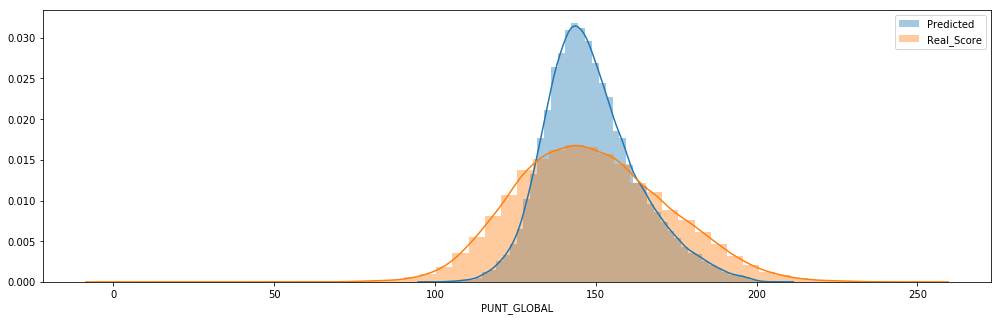

In [12]:
fig, axes = plt.subplots(figsize=(17, 5))

sns.distplot(lm1.predict(df_val), label='Predicted')
sns.distplot(df_val['PUNT_GLOBAL'], label='Real_Score')

plt.legend()
plt.show()

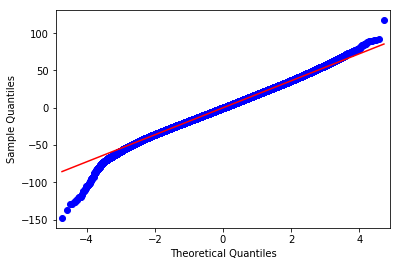

In [13]:
sm.qqplot(lm1.resid, line="s");

### Top and bottom variables:

In [22]:
lm1.params.sort_values(ascending=False).head(20)

Intercept                                                                     148.609147
Q("INST_NOMBRE_INSTITUCION_UNIVERSIDAD NACIONAL DE COLOMBIA")                   3.022017
Q("INST_CARACTER_ACADEMICO_UNIVERSIDAD")                                        1.917086
Q("ESTU_DEPTO_RESIDE_BOGOTA")                                                   1.882264
Q("ESTU_INSE_INDIVIDUAL")                                                       1.807706
Q("INST_NOMBRE_INSTITUCION_UNIVERSIDAD DE LOS ANDES")                           1.760666
Q("FAMI_NUMLIBROS_MÁS DE 100 LIBROS")                                           1.644891
Q("INST_NOMBRE_INSTITUCION_UNIVERSIDAD DE ANTIOQUIA")                           1.451050
Q("FAMI_NUMLIBROS_26 A 100 LIBROS")                                             1.394373
Q("ESTU_VALORMATRICULAUNIVERSIDAD_Mas de 7 millones")                           1.381323
Q("INST_NOMBRE_INSTITUCION_UNIVERSIDAD DEL NORTE")                              1.333367
Q("INST_NOMBRE_INSTIT

In [24]:
lm1.params.sort_values(ascending=False).tail(20)

Q("ESTU_DEPTO_RESIDE_CESAR")                                       -0.779691
Q("INST_NOMBRE_INSTITUCION_UNIVERSIDAD ECCI")                      -0.786219
Q("ESTU_DEPTO_RESIDE_BOLIVAR")                                     -0.817022
Q("INST_NOMBRE_INSTITUCION_UNIVERSIDAD ANTONIO NARIÑO")            -0.861288
Q("INST_NOMBRE_INSTITUCION_UNIVERSIDAD SIMON BOLIVAR")             -0.894151
Q("INST_NOMBRE_INSTITUCION_UNIVERSIDAD SANTIAGO DE CALI")          -0.928885
Q("FAMI_NUMLIBROS_nan")                                            -0.937843
Q("ESTU_DEDICACIONLECTURADIARIA_nan")                              -0.937843
Q("ESTU_AREARESIDE_Area Rural")                                    -0.978120
Q("ESTU_DEPTO_RESIDE_LA GUAJIRA")                                  -1.056632
Q("ESTU_DEPTO_RESIDE_CORDOBA")                                     -1.075137
Q("GRUPOREFERENCIA_EDUCACION")                                     -1.135112
Q("ESTU_METODO_PRGM_DISTANCIA/SEMI-PRESENCIAL")                    -1.151900

### Columns:

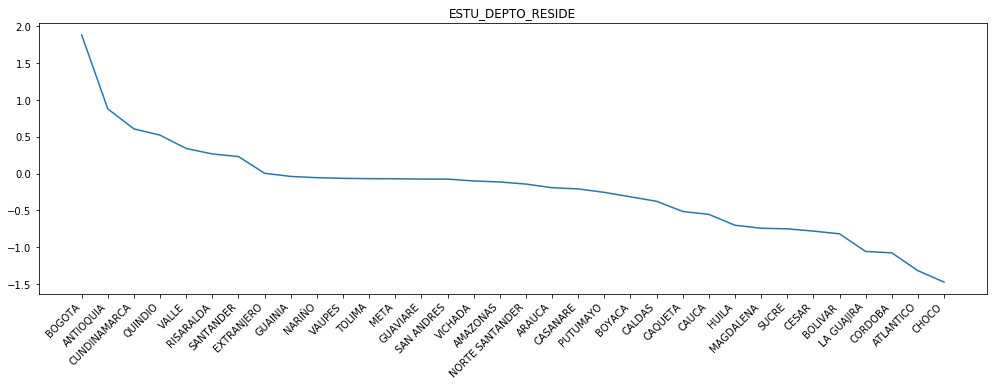

In [52]:
col_sel = 'ESTU_DEPTO_RESIDE'
ser_sel = lm1.params.sort_values(ascending=False).filter(like=col_sel,axis=0)
ser_idx = [col.split(col_sel)[-1][1:-2] for col in ser_sel.index]

fig, axes = plt.subplots(figsize=(17, 5))
sns.lineplot(ser_idx, ser_sel, sort=False)
plt.xticks(rotation=45, horizontalalignment='right')
plt.title(col_sel)
plt.show()

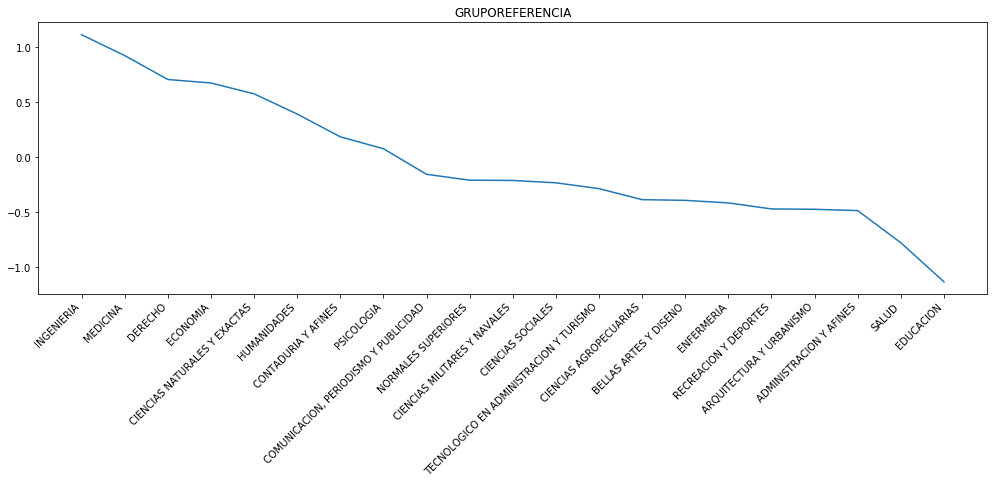

In [54]:
col_sel = 'GRUPOREFERENCIA'
ser_sel = lm1.params.sort_values(ascending=False).filter(like=col_sel,axis=0)
ser_idx = [col.split(col_sel)[-1][1:-2] for col in ser_sel.index]

fig, axes = plt.subplots(figsize=(17, 5))
sns.lineplot(ser_idx, ser_sel, sort=False)
plt.xticks(rotation=45, horizontalalignment='right')
plt.title(col_sel)
plt.show()

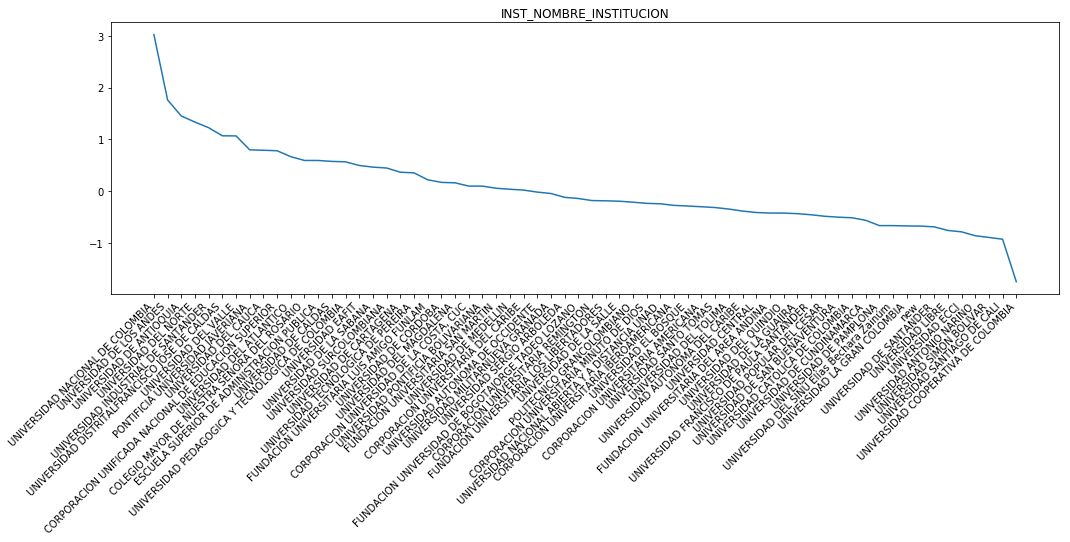

In [57]:
col_sel = 'INST_NOMBRE_INSTITUCION'
ser_sel = lm1.params.sort_values(ascending=False).filter(like=col_sel,axis=0)
ser_idx = [col.split(col_sel)[-1][1:-2] for col in ser_sel.index]

fig, axes = plt.subplots(figsize=(17, 5))
sns.lineplot(ser_idx, ser_sel, sort=False)
plt.xticks(rotation=45, horizontalalignment='right')
plt.title(col_sel)
plt.show()

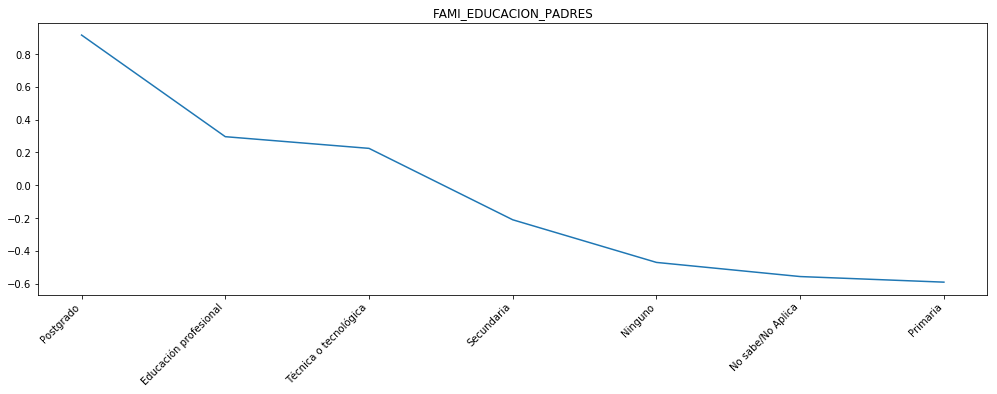

In [55]:
col_sel = 'FAMI_EDUCACION_PADRES'
ser_sel = lm1.params.sort_values(ascending=False).filter(like=col_sel,axis=0)
ser_idx = [col.split(col_sel)[-1][1:-2] for col in ser_sel.index]

fig, axes = plt.subplots(figsize=(17, 5))
sns.lineplot(ser_idx, ser_sel, sort=False)
plt.xticks(rotation=45, horizontalalignment='right')
plt.title(col_sel)
plt.show()

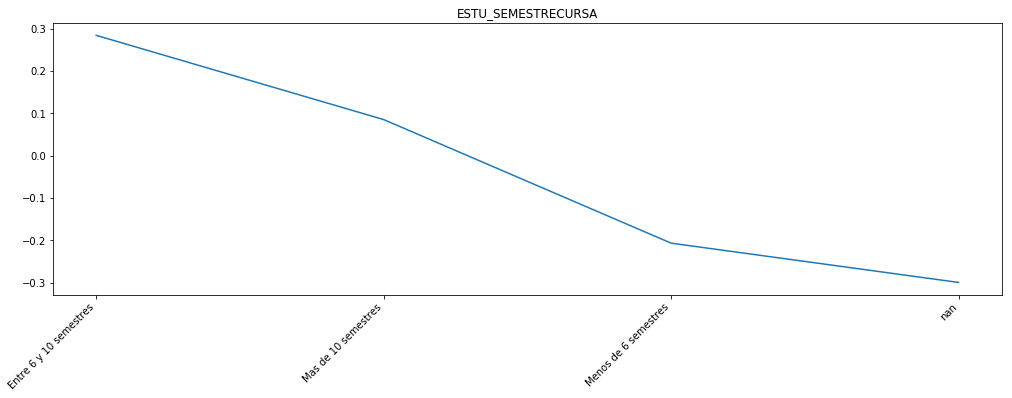

In [56]:
col_sel = 'ESTU_SEMESTRECURSA'
ser_sel = lm1.params.sort_values(ascending=False).filter(like=col_sel,axis=0)
ser_idx = [col.split(col_sel)[-1][1:-2] for col in ser_sel.index]

fig, axes = plt.subplots(figsize=(17, 5))
sns.lineplot(ser_idx, ser_sel, sort=False)
plt.xticks(rotation=45, horizontalalignment='right')
plt.title(col_sel)
plt.show()